In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import subprocess
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import urllib

import util

if 'TMPDIR' in os.environ:
    TMPDIR = os.environ['TMPDIR']
else:
    raise ValueError('TMPDIR not set')

In [3]:
product = 'etopo1'

In [4]:
# Parameters
product = "etopo1"


In [5]:
file_src_data = util.file_name_topo(product)
file_src_data

'/glade/work/mclong/etopo1/ETOPO1_Ice_c_gmt4.nc'

In [6]:
if not os.path.exists(file_src_data):
    if product == 'etopo1':    
        print('downloading etopo1')
        url = 'https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/cell_registered/netcdf'
        f_remote = f'{url}/ETOPO1_Ice_c_gmt4.grd.gz'        
        f_local = f'{TMPDIR}/ETOPO1_Ice_c_gmt4.grd'        
        urllib.request.urlretrieve(f_remote, f_local+'.gz')
        subprocess.run(['gunzip', '-f', f_local+'.gz'], check=True)
        subprocess.run(['mv', f_local, file_src_data])                     

xarray.Dataset {
dimensions:
	grid_rank = 2 ;
	grid_size = 233280000 ;
	grid_corners = 4 ;

variables:
	int32 grid_dims(grid_rank) ;
	float64 grid_center_lat(grid_size) ;
		grid_center_lat:units = degrees ;
	float64 grid_center_lon(grid_size) ;
		grid_center_lon:units = degrees ;
	float64 grid_corner_lat(grid_size, grid_corners) ;
		grid_corner_lat:units = degrees ;
	float64 grid_corner_lon(grid_size, grid_corners) ;
		grid_corner_lon:units = degrees ;
	int32 grid_imask(grid_size) ;
		grid_imask:units = unitless ;
	float64 grid_area(grid_size) ;
		grid_area:units = radians^2 ;
		grid_area:long_name = area weights ;

// global attributes:
	:title = 0.016666666666666666 x 0.016666666666666666 (lat x lon) grid ;
	:created_by = latlon_to_scrip ;
	:date_created = 2021-10-27 14:52:24.300291 ;
	:conventions = SCRIP ;
}CPU times: user 2.07 s, sys: 5.48 s, total: 7.54 s
Wall time: 21.7 s


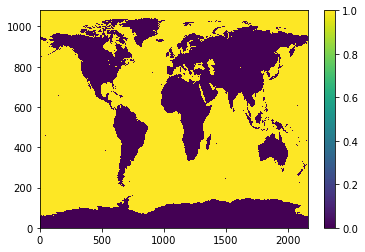

In [7]:
%%time
scrip_grid_file = util.file_name_grid(product)

if not os.path.exists(scrip_grid_file): 
    
    if product == 'etopo1':        
        # get/write scrip grid
        dso = util.latlon_to_scrip(
            nx=21600, 
            ny=10800, 
            lon0=-180., 
            file_out=scrip_grid_file
        )
else:
    dso = xr.open_dataset(scrip_grid_file)

    
# check that this conforms to the grid of the original dataset
ds = xr.open_dataset(file_src_data)
grid_imask = xr.where(ds.z < 0, 1., 0.).values.astype(np.int32)
plt.pcolormesh(grid_imask[::10, ::10])
plt.colorbar()
    
# extract grid coordinates to make check below
dims_grid = tuple(dso.grid_dims.values[::-1])
ny, nx = dims_grid
lat = dso.grid_center_lat.values.reshape(dims_grid)[:, 0]
lon = dso.grid_center_lon.values.reshape(dims_grid)[0, :]

np.testing.assert_allclose(lat, ds.y.values)
np.testing.assert_allclose(lon, ds.x.values)    
dso.info()